In [1]:
import paltas
from paltas.Analysis import hierarchical_inference
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import emcee
import corner
import numba
import os

np.random.seed(4)

# Running Hierarchical Inference on a Population of Strong Lenses

__Author:__ Sebastian Wagner-Carena

__Goals: Understand how to run hierarchical inference on the network outputs using `paltas`__ 

__If you have not already done so, you will have to install `tensorflow` to run the Analysis module tools in this notebook. This notebook will also take advantage of the package `emcee`, although you you can use any sampler you like. For the plotting we will use `corner`.__

## Making our data

To best illustrate how the hierarchical inference tools work, we'll generate a set of artificial network outputs. However, the pipeline outlined here will work equally well with true network outputs. To do this we need to simulate a) the prior we use for trianing and b) the information content of the image. We will focus only on the SHMF normalization and therefore assume that the information content of the image is very low compared to the prior.



In [2]:
# Define the true population mean and its scatter
true_mean = 1e-3
true_scatter = 3e-4

# Assume some consistent, large noise for all of our lens images
image_information_scatter = np.random.uniform(low=4e-3,high=6e-3,size=100)
image_mean = true_mean + np.random.normal(size=100)*image_information_scatter + np.random.normal(size=100)*true_scatter

# This in the mean and scatter of the information in each image, but remember our network predicts a posterior which means we need to multiply our likelihood
# by the training prior
train_mean = 2e-3
train_scatter = 1e-3
network_means = (image_mean * train_scatter**2 + train_mean*image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2)
network_scatter = np.sqrt((train_scatter**2 * image_information_scatter**2)/(train_scatter**2 + image_information_scatter**2))

(array([ 2.,  6.,  7., 18., 22., 15., 15.,  8.,  4.,  3.]),
 array([0.00153876, 0.00162715, 0.00171555, 0.00180394, 0.00189234,
        0.00198073, 0.00206912, 0.00215752, 0.00224591, 0.0023343 ,
        0.0024227 ]),
 <BarContainer object of 10 artists>)

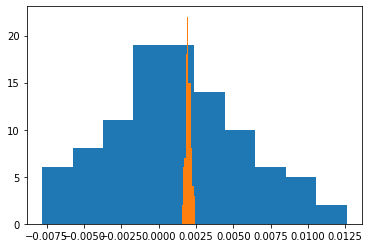

In [8]:
plt.hist(image_mean)
plt.hist(network_means)

(array([ 4.,  5., 11.,  4.,  2., 15., 14., 15., 11., 19.]),
 array([0.00097032, 0.00097191, 0.0009735 , 0.0009751 , 0.00097669,
        0.00097828, 0.00097987, 0.00098147, 0.00098306, 0.00098465,
        0.00098625]),
 <BarContainer object of 10 artists>)

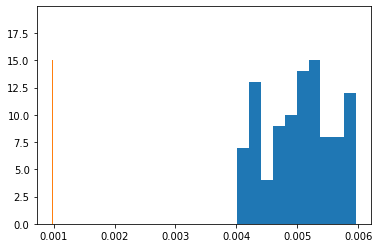

In [7]:
plt.hist(image_information_scatter)
plt.hist(network_scatter)

Now we have the image information and the network outputs. The network outputs are dominated by the prior. Quickly, let's confirm that a) if we combined the image information we would get a likelihood consistent with with the true mean and b) if we combine the network outputs we would get a likelihood consistent with the training mean.

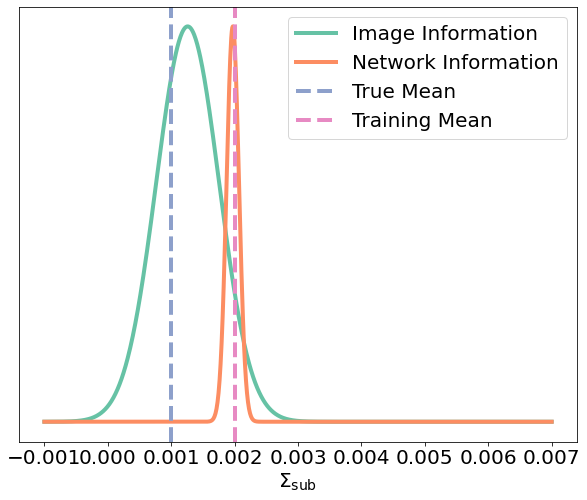

In [4]:
# Start by combining all the image level information
plt.figure(figsize=(10,8))
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
x = np.linspace(-1e-3,7e-3,1000)
prod = np.zeros(len(x))
for i in range(100):
    prod += norm(loc = image_mean[i],scale=image_information_scatter[i]).logpdf(x)
# Normalize the max to 1 for visualization
prod -= np.max(prod)
plt.plot(x,np.exp(prod),label='Image Information',c=colors[0],lw=4)

# Now combine the network outputs
prod = np.zeros(len(x))
for i in range(100):
    prod += norm(loc = network_means[i],scale=network_scatter[i]).logpdf(x)
prod -= np.max(prod)
plt.plot(x,np.exp(prod),label='Network Information',c=colors[1],lw=4)
plt.axvline(true_mean,label='True Mean',c=colors[2],lw=4,ls='--')
plt.axvline(train_mean,label='Training Mean',c=colors[3],lw=4,ls='--')
plt.legend(fontsize=20)
plt.xlabel(r'$\Sigma_\mathrm{sub}$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([])
plt.show()

Note because there is scatter in our true values, the combination we did above is not statistically correct, but it gives us a good idea of the challenges we face. The information about the population mean exists in the sample, but it washed out by the prior in the posteriors our network is estimating.

## Hierarchical Inference

Now we can use our hierarchical inference tools to combine the network outputs and attempt to infer the population mean and scatter of the SHMF normalization.

All of the work gets done by `hierarchical_inference.ProbabilityClassAnalytical` and `emcee`. `ProbabilityClassAnalytical` needs to be initialized with the mean vector and covariance matrix defining the interim training distribution (this class assumed that every distribution being considered is a multivariate Gaussian, but there are other classes in `hierarchical_inference.py` that relax that assumption at the cost of computational time).

In [6]:
# Let's define a few of the parameters for our inference
n_lenses = 100
n_emcee_samps = int(1e4)
burnin = int(1e3)
chains_folder = 'notebook_data/'
backend_path = 'example_chains.h5'
chains_path = os.path.join(chains_folder,backend_path)

# Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
# expect an array of mean values and a precision matrix.
y_pred = network_means[:n_lenses].reshape((n_lenses,1))
prec_pred = 1/np.square(network_scatter[:n_lenses].reshape((n_lenses,1,1)))

# The interim training distribution.
mu_omega_i = np.array([train_mean])
cov_omega_i =np.diag(np.array([train_scatter])**2)

# We will want to initialize emcee near the correct values.
mu_omega = np.array([true_mean])
cov_omega =np.diag(np.array([true_scatter])**2)
true_hyperparameters = np.concatenate([mu_omega,np.log(np.diag(np.sqrt(cov_omega)))])

# A prior function that mainly just bounds the uncertainty estimation.
@numba.njit()
def eval_func_omega(hyperparameters):
    # Enforce that the SHMF normalization is not negative
    if hyperparameters[0] < 0:
        return -np.inf
    # Need to set bounds to avoid random singular matrix proposals
    if hyperparameters[1] < -12:
        return -np.inf
    return 0

# Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
# pooling.
prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
prob_class.set_predictions(mu_pred_array_input=y_pred,prec_pred_array_input=prec_pred)

# Set a few of the parameters we will need to pass to emcee
n_walkers = 40
ndim = 2

# Generate an initial state around the true values (this helps with convergence for this example) 
initial_std = np.array([5e-4,1])
cur_state = (np.random.rand(n_walkers, ndim)*2-1)*initial_std
cur_state += true_hyperparameters

backend = emcee.backends.HDFBackend(chains_path)
sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega,backend=backend)
sampler.run_mcmc(cur_state,n_emcee_samps,progress=True)
chain = sampler.chain[:,burnin:,:].reshape((-1,2))

  0%|          | 2/10000 [00:00<14:22, 11.59it/s]

1.2284606065853048
1.3269882760675955
1.2847642549075262
1.2542409921878117
1.201369522087291
1.3739636071525183
1.374951477930189
1.3956373077105555
1.352871644980214
1.3930236779875536
0.9749475841844415
1.2579281971950453
1.3471369501320671
1.260841174814118
1.0545333594880688
1.3853918152330307
1.213689520884504
1.3733466252690896
0.7136077471053
1.2328712362927425
1.2721827467728848
1.0311296477366594
1.177680120952528
1.0506909157082502
0.9933197285890807
0.917449916033789
1.3625467822057722
1.2459082170301534
1.2837571376951598
1.350003978014474
1.041955106732388
0.28572872940868077
0.5375673038194917
1.2943452878229693
1.3453993204928008
1.4171940793094429
1.3987979045317935
1.3251932289180615
1.4269383850234973
1.2656988644733822
1.2479986311763298
1.3666287325787079
1.3739636071525183
1.394098627775847
0.8879156729685574
1.091949832478579
1.3226647117595007
1.3649840537403453
1.2835576984442225
0.13302466494987186
0.5375673038194917
0.9980039193713284
1.3296317229971457
1.424

  0%|          | 4/10000 [00:00<14:12, 11.72it/s]

1.2225149043708607
0.033484168133554704
1.3729978903580018
1.3619058158081487
1.1146751836645903
-0.16279299958982013
1.3648730528823299
1.257221289961426
0.4958667572024076
0.16058305110351562
1.1365599375447097
1.340487878299884
0.13134648211243172
0.28572872940868077
1.1733319515350202
1.0551191679824505
1.4058605929418668
1.2669723149678904
1.329005816120309
1.198144337790453
1.3850790487070306
1.3933491896932217
1.3182047687603893
0.991886768782471
-2.9223030735593056
1.2300538071779883
1.367955926789687
1.2810870193783181
1.014593928872598
0.836830522643913
0.7833435333066525
1.0543012952169661
-1.2580121838552687
1.4208848931712055
1.4266669102070821
0.8574526553235273
1.1360142560679831
1.235185948450608
0.5207347062735721
1.0938098736400832
0.033484168133554704
1.428859203280382
1.1075925547908403
1.3182047687603893
0.6465654267915205
1.3756940774449777
1.2518260871939786
1.0449876315739672
-2.9223030735593056
1.3380949507051199
0.836830522643913
1.0688125850624424
-0.83753211

  0%|          | 8/10000 [00:00<13:58, 11.92it/s]

1.0804565339097087
0.033484168133554704
1.3777674802887736
1.3500123925290435
1.1075925547908403
1.3962959733892815
1.294290749504396
1.2634290660749974
-1.5463851110489486
1.3662870022900222
0.17565079885027401
0.6830728481059118
1.0688125850624424
1.4231000149456108
1.1178196777419203
1.094672692371649
1.4172272131715076
-0.26905888877960216
0.18737490004642154
0.8548194998182816
1.4304544411992879
1.3182047687603893
0.9947360423225903
1.3658695583959113
0.6660353874223659
1.3908968581470686
-0.05370432348486745
0.7715667942206663
0.437306637716614
1.3893562176797047
0.9692974844903475
-0.21434297404594105
-2.076225836464559
-0.8375321164693807
-0.41107496032762164
1.4171904149346801
1.1258030565496693
1.2669723149678904
1.2623733623775955
1.284196657925035
0.9566788160599629
1.4134224194100682
1.3717886567248483
1.3500123925290435
1.3551713747995322
0.9768390080023157
1.1574241053505752
0.9313850261366253
0.6660353874223659
-0.9984845779190437
1.0691337077105416
1.3893562176797047
0

  0%|          | 10/10000 [00:00<13:07, 12.69it/s]

1.2476748525277073
1.254403123019074
1.3962959733892815
1.2189258723932994
0.6356403591176645
0.42656276321625963
-0.9475071411825411
0.3517775458270107
1.150921007105639
1.3059077801228804
-1.3536395212611865
1.3113651481037376
-0.7809140570942574
0.48560453819659494
1.3220534651464622
0.3167433636532848
1.1183171668901792
1.1117336919243996
1.3184881487555038
1.127028799613686
1.2476748525277073
0.9399138117088695
1.2189258723932994
1.3290277218043443
0.42656276321625963
0.9932992257001607
1.1940022116599622
-0.05006585176130329
0.3517775458270107
1.3059077801228804
1.379375380979262
1.3900313807060707
0.48560453819659494
1.4175456615864057
-0.5127331271648736
1.2235579215921462
0.19055739792179338
0.5019757226660371
1.1304755621534357
-1.1473367200586466
-0.8706405310075525
0.7999729230015713
1.2255156420657067
0.5563367014081178
1.3962959733892815
0.6356403591176645
0.6618512254395554
-1.3310205739398953
0.23245790249474307
1.1305384292511476
0.2873852559968242
-0.7809140570942574


  0%|          | 14/10000 [00:01<13:00, 12.79it/s]

-2.0120649968339284
0.6620342639792617
-0.6574142629670696
1.371503843335157
0.6815972030895239
1.1475192987083105
1.269384867898985
1.1257238042185849
0.4344853355053828
1.1740836042210234
1.392365754964958
0.8567699121409662
1.4168724581842618
0.5434098084329371
1.3850615054622537
1.1390416161267325
1.3059487209766534
1.3987997269019612
1.2744955205403983
1.1494074198330235
1.2593720876118617
0.6620342639792617
0.6815972030895239
0.6574694038832765
1.1501339907414945
-0.15940842189957038
0.9462670837847713
1.2385466551627415
1.1588520870333632
0.7538758648649644
1.0544404948760722
0.8567699121409662
1.262874162181486
1.4315502792875634
1.0301762413320006
1.116049301393872
1.3049676709208597
1.3004173060672706
0.5439424792787406
0.8159681632712541
-0.8706405310075525
0.6344581470572611
1.3100808990434434
0.31840089618145684
1.3703637743532937
1.3448614873611362
1.1127054094468534
-0.41494484977212054
0.8845972102425321
0.17343927061736572
0.4344853355053828
1.3754364682885845
0.354427

  0%|          | 16/10000 [00:01<13:09, 12.65it/s]

-0.07982723932298086
1.0849814459117368
0.274262988856421
0.5540518554475323
1.2703793060240856
-0.2342479440126361
1.0840566576780475
0.17343927061736572
1.2060534671346446
0.521992541388709
0.6780601348727471
1.3637834343953434
1.4228504092120602
1.418207394047613
-1.9231358477206493
1.1928019469022715
1.3302041415518033
1.3252089467245938
1.235005988217324
0.8159681632712541
1.2558693574918536
0.7302478211070933
-0.27510595518704123
1.2958956050166837
1.0639197967581069
0.7219265894199012
0.22574856600781068
0.698520239161212
0.9462670837847713
-0.5030964913993556
1.1823014985233185
1.410459752350679
-1.4422404026341442
0.8567699121409662
0.5434098084329371
1.226031383668886
0.9032422068903507
1.299445230986111
1.405671271860621
-0.2178494183104931
1.2558693574918536
-0.7184918732647816
1.2958956050166837
1.0849814459117368
-0.2342479440126361
-0.35784774155217747
0.050736293418288406
0.8184397135879726
0.21508673382942955
-0.05266423787908625
0.6595938566672634
1.340283827788575
-0

  0%|          | 20/10000 [00:01<13:10, 12.62it/s]

1.2459650214106972
0.6480260835932066
0.6682550606179832
1.3631316326599388
-0.24533299707985634
-0.26492170308616503
0.9398762752165197
1.2039964087202435
0.9462670837847713
1.3208318830096544
-0.05266423787908625
1.1482534310532486
1.1575242126875622
1.4228504092120602
0.45000903688918426
1.0642880105106534
1.268770814266702
1.403877739416922
0.5813493468701836
0.9920006740083518
1.1744547259669034
1.2133330036847383
0.3073988161693251
1.0936887058579807
1.2063445966316613
-0.3428818332931769
1.4297125306143244
0.568723144518676
0.7370083604761684
0.45952310167424315
0.5906870586146908
0.6034737992336829
0.892450819406811
0.2944205370919587
1.0388307243318926
1.203855341923827
1.4300399546377776
1.1327516292781006
1.1717611911528936
1.378773403291544
0.6480260835932066
1.2313945174841656
-0.7796426947534201
1.00792623227915
0.35677379593861014
1.0716969446396831
1.1505673430683814
0.9462670837847713
0.568723144518676
0.8752839627977149
0.5462772113781389
-0.36963220079387504
-0.18080

  0%|          | 22/10000 [00:01<14:50, 11.21it/s]

1.3823929975732625
0.6480260835932066
0.6682550606179832
0.6341339972254545
0.6489817808922567
1.2919819378094708
1.2190859708406787
-0.022445794587986567
-0.3428818332931769
1.408287073372776
0.6546160793376115
1.3768835067067045
1.3399621383144265
1.425276787962929
1.397946687244481
1.1240252360072545
1.2668654040541867
1.1336788845432997
1.3600566988292924
0.49127230597407073
1.4241133817492084
0.6480260835932066
1.4099189894870232
-0.6408738496775186
-0.9835223225845766
1.2594087870549657
1.3642188358677458
1.2707401174075432
0.2930970017796466
1.3088499655993189
0.4507718688563201
1.376027181442499
1.348727409905817
0.5055288197490613
1.3982917551206242
1.2676909504664877
1.2166216243103238
1.1336788845432997
1.3476887953025258
1.3273301655428362
1.3008130827455766
0.6682550606179832
0.6489817808922567
-1.5964956663617327
-1.6336965703321766
1.408287073372776
0.6081776168723638
1.3720059325280545
-1.1998453784105512
0.7215381557018361
1.281191951552458
-0.5814795411980782
-0.43576

  0%|          | 24/10000 [00:02<15:35, 10.67it/s]

0.6682550606179832
0.9726568231039341
-0.9835223225845766
-1.5964956663617327
0.9099324455106341
-1.4819476168965129
-1.6336965703321766
1.1569945299439044
0.4507718688563201
1.1700147329819277
0.22958721431660223
1.3866673609441662
-0.4487377185006439
1.3982917551206242
1.3562033924090429
1.399725649916407
1.1676732046462917
1.3085291789300495
1.385416988672831
1.3344048453979407
1.1208465352655848
1.3063526363720541
1.0119229215852004
0.752950075759486
-0.9055608279322769
1.2594087870549657
0.540674482006839
1.3300258985777873
1.0723677939991028
1.4297443299430483
0.7215381557018361
-0.2630931616211267
1.4017826558280433
1.3444826801794427
1.4250595251965237
-0.8042041282906396
0.9187077449137613
1.2166216243103238
1.3685191476396312
1.1084334204733506
1.1224496582596135
0.752950075759486
-0.9055608279322769
0.2928248255846029
-1.4819476168965129
-1.6336965703321766
1.2209221100120455
1.2568847681641273
1.1925195280672773
1.0723677939991028
1.2689631584325234
0.8033373261737324
0.313

  0%|          | 26/10000 [00:02<15:05, 11.02it/s]

1.3623893232509001
0.7690672315514981
-1.4281014531151701
0.9538987642592502
-0.9055608279322769
1.352459232538493
1.250262431991855
1.400200961894143
-1.5223736708459032
-0.15686503426678175
1.048574117731015
1.4077081651047898
1.170736911897075
1.2550614502675908
-0.4487377185006439
-5.6804829644259005
1.2384296213485015
1.155182363088045
1.2957865788107776
0.9358327162628326
1.3898022200246514
1.1688511821012506
0.3075844203937086
-0.9943970324366092
0.7132169738791065
1.1647827397000583
0.5808093833155406
0.7960334422804252
1.0905138735665787
1.1223087287783864
1.3013914065771388
1.321355957255804
1.397932499140218
1.1449725405489062
1.4214500606251477
1.2830291580338713
0.5136404878022786
0.5707579642845992
1.0126500453883955
1.1246178947176304
1.1688511821012506
1.044260954470026
-1.4281014531151701
1.2090525960251384
-0.035264483660284895
1.2453081879375532
1.048574117731015
0.25324464821918014
1.0905138735665787
0.4844827346403777
1.3798977472043958
1.1973518308915487
1.1674069

  0%|          | 30/10000 [00:02<14:30, 11.46it/s]

1.3728902329501764
1.1882391813783872
1.1329450480088212
0.9429342147853519
-1.5223736708459032
0.476171172443145
0.37164986220655105
1.3268213407319975
0.8425977843579924
1.2279149231668818
1.1985623527136218
1.1753199371355123
-0.10049636761683381
-0.5168870474792633
1.1862802935493022
1.3952853648043622
1.1387094680597052
1.3220408513615354
0.8528433531507817
1.1088435072915672
1.412999427145568
0.8308665288203585
-1.4281014531151701
0.1874670761849302
1.3150827395511229
1.40234025203074
1.3830785899452849
1.0753489324285437
1.2453081879375532
0.6036468829214527
1.3798977472043958
1.3305799035112926
1.3768305554304447
1.4093711805940075
-2.7485033538879087
1.068699349797967
0.49217100950719583
0.25506397313089835
0.1998312201691732
0.9358327162628326
-0.41701887096595414
1.150835915056689
1.4111339230429394
-1.5223736708459032
1.3709710518618685
0.7554986971333614
1.2009162006792202
1.2754481020778528
-0.10049636761683381
0.14833497843368953
1.4262729894225572
1.311747082822997
1.42

  0%|          | 32/10000 [00:02<16:11, 10.26it/s]

0.22409431570104793
1.406225520149306
0.7882001899283573
1.2720861831411412
1.3389788776917522
0.8069314999408668
0.823533466013032
1.4050388784792176
0.8840848883685859
1.2453081879375532
1.3758996629793359
-0.2925456790534451
0.8799137764940212
1.374799968467208
1.095839179610551
1.4223677180605137
1.2542979246355586
1.2682362471114175
0.1972948891086732
1.006206698923961
0.7273616570589638
1.3527390882312318
1.4050388784792176
-1.5223736708459032
0.8953007130782149
1.3608020039956727
1.4111793668602104
-1.80192076136685
0.6268120640820598
0.8016655345761752
1.3013971658614811
-1.773688985574477
1.0179753829968234
1.2682362471114175
-1.0258359176165222
0.1972948891086732
1.4279854900618147
0.6170207745911453
0.20919703300968387
1.4142064047157419
1.4006421198318328
0.7236632714110351
1.4201974127205546
-0.3092206483389397
1.28748657487699
0.5710361978066203
0.6526784610617498
1.2359200198443432
1.2549820943309058
1.2034655870595685
0.5376930822994752
0.9017181836823909
1.382359479547

  0%|          | 34/10000 [00:02<16:08, 10.29it/s]

1.3956901441987881
1.28748657487699
0.7273616570589638
1.3136194031190094
0.8595088499054526
0.4632729823367754
1.2435523493898462
-1.80192076136685
0.4651350571580224
0.9017181836823909
1.2523549669957674
0.7305822396055959
-1.773688985574477
1.129146889812482
1.4187363269447815
-1.5661881654597964
1.4279508970383006
1.2235854833011786
1.2920427641624954
1.4142064047157419
0.7442563285078962
0.6937105818576583
0.06721592720195779
1.3136194031190094
0.7169876107512164
1.4317667460472308
-0.6112164784715111
0.8595088499054526
1.1356345231845069
1.2435523493898462
0.4763126738228901
0.9017181836823909
-0.07670222357739664
0.5292114620886963
1.2779365353356087
-1.773688985574477
0.8611592802995531
1.4187363269447815
1.4046766118090943
1.212435042363964
1.3723018032234222
0.475518725960967
0.7273616570589638
-1.3735530940102763
1.270264480498895
1.3938385163415283
0.45820970169597786
-1.80192076136685
0.8254538575125139
1.189001759340547
1.4023804992699525
1.050776352005414
1.1690042331878

  0%|          | 38/10000 [00:03<14:27, 11.48it/s]

-1.1374537646914595
0.7510179910960844
0.010412173011879855
-1.5797291761675751
1.2919923987082598
-0.6112164784715111
1.421813364595316
0.35579055064886234
-4.257765728370541
1.2740233848494995
1.1408063510165207
0.9548324468907574
1.2111290335250038
1.4263754728486617
0.8796966804245869
0.39926407278398557
1.1495190477043167
1.297283245139789
0.7066408952364327
0.8420071951064431
0.4289079271202051
-0.4925947712529115
1.0357997354893769
-1.5797291761675751
1.3799753829879204
0.3828844482943623
-0.25144513513430455
0.9343209971152078
1.410874883633781
1.0859571154641117
0.20525331464865104
0.9702689270008651
1.1565801622474499
-1.051559594184015
0.7916418954264373
1.4190057594545173
1.3841739753062017
0.4041066857878164
1.354245469372021
1.1495190477043167
-1.1374537646914595
0.3070492568415375
1.4018616763277407
0.8263284539469353
0.3589678251147461
0.6196501440458082
0.7342254085249564
-4.257765728370541
-0.27243645646696324
1.2740233848494995
0.8925748868945009
0.9325973669191874
0

  0%|          | 40/10000 [00:03<15:16, 10.87it/s]


0.3070492568415375
1.3475118200980205
0.3900645300917982
1.1488085778460118
1.2320722649109985
-0.1434718757736846
0.9331985368041273
0.6196501440458082
0.9365700997873034
0.9042750852701443
-0.32622391040909804
0.7358474745349313
-0.5582739954161866
-0.14105644354160596
1.0050621522580612
1.0653017115805596
1.3994135778717691
1.4286763030439573
0.8420071951064431
0.24152493678544262
-0.8387901418520869
0.18037111961378471
1.2725299842653044
-0.6398409795282769
1.2395834106532284
0.3167608955723722
-1.0894472880369905
1.165420683941885
-0.13840867709821958
0.9978866761907739
1.2994055692577149
1.4190589120880759
1.390158548533762
1.3187880201416604
1.299168675818521
1.2841678613806948
1.39104489046926
0.8805999613093187
-0.6309708705969115
0.24152493678544262
0.3070492568415375
1.323000709826033
1.1488085778460118
0.49623015912897017
0.3634011643030135
1.3692243313116697
0.44290677966443504
0.9042750852701443
1.158256962164994
1.1669280822672439
1.1182988566377805
0.9978866761907739
1

  0%|          | 42/10000 [00:03<15:05, 10.99it/s]

-0.7708817423122127
1.368426960551119
0.18037111961378471
1.2511306887072235
1.118912878471372
1.422337199064657
0.3801255676383488
-0.2525976001587509
1.425100434886069
1.1483316296555834
-0.6524018287561884
1.4263797524344
1.4260512635278815
-0.9166825491336112
1.0828879021802322
1.42906563433705
1.3765698132101534
1.3793377109276834
0.9735845207483396
-0.3369521309855152
1.352561607392456
1.3935985472425045
-0.03354097159427738
-1.7685875659985868
-1.5303254573216236
0.25211902427654653
-0.1931654551287343
-1.5697644377227826
0.441284782406583
0.26526293143875307
1.1998833924562007
0.8682008618516117
1.430694351505025
1.0653017115805596
1.4070391350767864
1.3254582604982996
1.0504455553255951
1.3786847080638198
0.9253679044636556
-0.3369521309855152
0.5986467746960418
-0.7708817423122127
0.8050265048210038
0.9764118209785604
0.21357553382650707
0.14649687083147
0.3634011643030135
1.1606725473536479
1.2383224449232797
1.4166925557771037
1.2752694958330295
-1.5510509725244253
1.410011

  0%|          | 44/10000 [00:03<13:59, 11.86it/s]

1.352561607392456
-0.7708817423122127
1.4001752654758093
1.2780889097249926
0.5951694991277066
-0.38436872832323843
0.9843544007862555
0.10243259906678759
0.9836668115162865
1.398269516045758
0.9071333840113525
-1.7032940489426296
0.726678827670766
1.4076191302430736
1.3522355818229812
1.0946360396378623
1.1701951812667843
1.2663039255462998
1.429178459564497
0.9906852005607334
1.274703405629021
-0.7708817423122127
1.2401196395108727
1.0177266427709597
0.9429381329164244
1.3755260625331793
0.6540614391308175
1.1938194068763242
-0.3591421122145566
0.4221950916423597
0.8996995145573266
1.3037139090898435
1.4267180932736068
0.5587651098385322
1.4142517006122262
1.2663039255462998
0.8165473794130751
1.4295869245854647
1.3952017884897039
1.1017396772327857
1.352561607392456
1.4001752654758093
1.2783562031449547
-0.38436872832323843
1.379401040249248
1.0345511652314485
0.27460509471677597
-0.8059108932050525
0.8348376268068898
1.3171702299537174
-0.30797284871470154
0.7626382134375079
1.3961

  0%|          | 48/10000 [00:04<14:11, 11.69it/s]

0.5908325578261324
1.3486385520720798
0.2989411741232928
0.9727774262430735
0.6305240017800315
0.9429381329164244
0.8824572800253648
1.3755964367132645
0.8419588379974288
1.3757902897859822
1.357867112782742
1.4230792946104884
0.4847541369582018
0.42648136895854805
1.2663039255462998
1.428281693624882
0.06741409161514167
0.9623631815593323
1.1673813674290727
1.3874862012601579
1.0861426489831842
1.3763599155191457
1.423027747346623
-0.8742804612413326
1.323481761010319
1.3187490687119094
-0.8059108932050525
0.05332292396505073
1.341029358411447
1.3171702299537174
0.6540614391308175
-0.032598782209251054
1.1690999135843465
0.5957956070523593
1.01662826575123
1.082505850622077
1.2880099301579406
1.2679225927550093
1.429699034191799
1.4082337785038845
1.3251778742467764
1.4282076975669042
1.323481761010319
1.1597304557554367
1.2409131091445715
0.9429381329164244
0.9274376060932337
1.2544841417403205
0.5897644876849242
-0.032598782209251054
1.01662826575123
1.1664620961909646
1.06101205893

  0%|          | 50/10000 [00:04<14:22, 11.54it/s]

0.5908325578261324
1.3515204090027453
0.740568159043562
0.2989411741232928
0.9705983751246507
0.8851709326035166
1.336456751819128
-0.10834289596878821
1.0264156032678784
1.3380155772045441
-0.13683058258985958
1.2048728031031812
1.0490112534082527
1.2945606814676651
1.419339945139086
0.6795431786704285
1.1346366035660216
1.430941917798009
1.0187650385582123
1.2061658139610358
1.0681372178889883
1.2683268624024322
1.4272812700728537
0.6069790786805243
0.34915957681174703
1.3753320682938863
1.0371020153673811
1.2369969519770194
1.1885608040511606
1.3967851368221886
0.7989398776075944
1.399268048490356
0.12882004903154484
1.3738916821559588
1.4132505275720177
1.173953813893604
1.3657491461202094
1.4324076229499951
1.3444839473578192
1.3959776275438642
1.2683268624024322
1.3318875613327208
1.305755070045052
-0.10834289596878821
1.3801872946572757
0.2059066400897791
0.6303012860899784
1.3967851368221886
0.7989398776075944
1.399268048490356
1.3602007278498256
1.2109589456931644
1.4132505275

  1%|          | 52/10000 [00:04<14:41, 11.28it/s]

0.5908325578261324
1.2636388027285648
-0.42544625305959016
1.4190259537235406
0.7992773467042866
1.3433849572657692
-1.60154805868342
1.1621381017781327
0.3431452975093423
0.8583372857898113
1.4132505275720177
1.229026245827522
1.4036019254853045
-0.9437934500165883
1.403584248090283
0.8494335864030198
1.3657491461202094
1.4324076229499951
1.2886455572597413
1.415965294843204
1.2394011547029635
1.4316912572777483
1.3111819153560162
1.3927608608786821
-0.42544625305959016
1.4209123238923524
0.7992773467042866
-0.12370398088023649
0.7985492485131986
-0.5006343117286178
1.2351590997143997
0.8583372857898113
1.2694928736531135
1.4304158485268772
1.229026245827522
-0.9437934500165883
1.403584248090283
1.1349441127651545
1.4320878993453334
1.4297846447867215
0.5185318765080085
0.06954496297100832
1.2490653588829446
0.5967154349916015
1.3433849572657692
1.428023298677104
-0.28857710533395675
1.116960510207953
-0.7521154508096487
-0.2116883582977746
1.4068322594575857
1.3081971028041153
1.3760

  1%|          | 56/10000 [00:04<14:35, 11.35it/s]

-0.42544625305959016
0.5967154349916015
-0.28857710533395675
1.259965359486209
-0.7521154508096487
0.7464636434932629
1.28071023656097
0.4591354642739134
1.1881379907137442
1.1531498458685945
1.2361024864602628
1.3200938529353152
-1.780324555857078
0.6376085680305783
1.405866669695115
0.7833756279371444
0.4954981518905825
1.3437498859784114
1.3799749632388796
1.3072479892213664
0.8975392016492518
1.306190024388116
1.0878316659596337
1.3629953313429723
1.353284984640453
0.5771220344481622
1.338179635036255
0.9454018812331197
1.2718921744271938
-0.12370398088023649
0.9046063460058524
1.4018098013516465
1.13433370987957
1.2628771440587627
0.4277467505105028
1.322149182279401
1.4161182430266308
1.0318492732932327
1.274236612887762
1.4228884741445427
1.097521432935706
1.4143691919849743
0.7088198826471335
0.20815675436452352
1.3713460995427909
1.2592597491508855
-0.15093892754890129
0.9421670661152817
0.4591354642739134
0.774395234885283
1.2001307825553442
1.4161182430266308
1.2361024864602

  1%|          | 60/10000 [00:05<13:54, 11.91it/s]

1.275236040195006
1.2776264078428454
1.2604680186368615
1.028589715981024
0.5391310504746798
-0.21922142308071635
1.3487886957345694
1.0237220960509354
1.3310923113014543
1.3926205331678503
1.0724881762147864
1.3755425598037618
-1.780324555857078
1.4007605057977344
1.0510835768597326
-0.28102742355581994
1.366930503751064
0.9668269501283966
1.4257065674353413
0.4712825920499881
1.2781475850353203
1.4288543924485566
0.8722992760913257
0.47821929167525923
0.5220668246350113
1.2705237687005138
1.0295131494049312
1.4127801773915962
1.2812369246816608
1.4072217594381016
1.3969727999594284
0.5630501871378328
0.7035288755888299
0.4591354642739134
0.6648730839452597
1.2575074422597936
0.9702879181090793
-0.2802229919008389
1.424253650386504
0.697862913092071
1.2156607337188277
1.2450427762564251
1.261506428125203
1.0885380690534474
1.2705237687005138
1.1414353800682875
1.2615347075133627
0.5630501871378328
1.216082265478505
0.5569562213467723
1.3945139065376733
1.181022984066658
0.970287918109

  1%|          | 62/10000 [00:05<13:38, 12.14it/s]

1.2855515246332914
1.2641560727131012
1.1530701054728247
1.0510915899280349
0.9519022459386175
0.657083079205895
1.033406026209363
0.7351418715588431
0.6220650336957494
0.09380309440575729
1.216327016381161
1.1690725796818526
0.8047438967583673
1.3754687243401307
1.3438856046648198
1.279058482674408
1.1296848703148328
1.3467743636483513
1.3387019431756926
0.976415820217369
1.4079371523051236
1.1399001573186622
1.2705237687005138
0.8951028585399854
1.4312485333475706
0.9253440166274629
1.4243479172615423
0.9252379310872527
0.39831663002001777
0.754379489794106
-0.28864507071721235
1.2032608150714117
1.181022984066658
1.0989422513529234
-0.8725929598202771
1.412852753960351
1.1681655183383555
1.3999151055886614
1.3356206043398036
1.4079100021882027
0.6103466006803551
1.4081548472531509
1.1530701054728247
1.4078712975887697
1.4306429126372677
1.430491200864708
1.3870456858148543
0.6220650336957494
1.3053497577759643
1.0667380340950956
0.7235585676632463
1.1683903512659413
-0.2886450707172

  1%|          | 66/10000 [00:05<13:10, 12.56it/s]

0.6529745335626718
1.3898818616570736
1.3945650315051523
1.1266441549327482
1.3845799965050745
1.2672028599118899
1.4306429126372677
-0.029907566789606765
1.207781441685139
1.219672005902373
0.7622353866108913
0.8623969223453543
0.7070877527276807
1.3292964346825045
1.3247266089770164
1.3829390428627484
1.1681655183383555
1.4248079821492183
0.2725659803369422
1.4289053192005952
1.2613711630071887
1.2681997539564533
0.9468685674508972
0.2556481271640223
1.172466067206642
0.31390402287973984
0.842838042244864
0.7381123535720822
0.8577551084735102
-1.6529139925943073
1.3680682935578972
1.1585501860185392
1.179157040283826
0.86645860528904
1.338820202952074
0.7784706308389104
1.3983316727571946
1.4125446875917191
1.4271038054248493
-0.17775845941139323
1.2644448247639133
1.372483157027851
1.3627600671373603
0.5064346826999788
1.2672028599118899
0.6411513013882626
0.6275407816437073
1.219672005902373
-0.7060287966811378
0.23381324052167618
1.3556548508000787
1.179157040283826
1.324726608977

  1%|          | 68/10000 [00:05<12:29, 13.25it/s]

1.3558367155711295
1.3450745970941629
0.688367964080129
-0.5589776956249572
1.2769494207047956
0.21059158710952264
1.0342327547331251
1.0010079522093491
-0.6633641025629604
-0.9246753545477158
1.301199388313961
1.1585501860185392
-1.0251496622138774
0.6004282672561203
1.2545741277147044
1.420425763779349
1.4281593287951182
1.2237821578425887
1.4144254297395946
1.4126993622813302
1.3471485579537115
1.233861272678288
-0.44737695867165084
1.3283380365951416
1.1073721204689377
1.4278181739027787
0.1302836861619845
-0.6633641025629604
0.6971561072386713
1.3149652931543825
1.2167363688581645
-1.0251496622138774
1.0779623113052708
1.2906910219362544
1.0997909914240154
1.4260557395755313
1.2237821578425887
1.3329863409894642
1.4227765153306962
1.1515088254305397
0.5894013238117606
1.1963838477556124
0.5323015776035902
1.341535265018455
1.4076992346609956
0.7177964369643561
0.9544356827591232
0.43684558268627427
0.21059158710952264
1.0498065629953999
1.2036989978094823
1.3728451567988982
-0.924

  1%|          | 72/10000 [00:06<12:03, 13.71it/s]

0.7087312226140838
1.3119102224633856
0.9532842071275889
1.4060756177850635
0.9282588061442709
1.0008138255060999
0.2704514915961056
1.4260753831176771
0.11659385395915667
1.2036989978094823
1.2412465621733968
0.8487625309073982
-1.4021721601669037
0.7009381271611188
-0.08961521280286888
1.386599971202486
1.2390927270473782
1.2326803009863885
1.4286040267037095
-0.08919544534198565
1.2169141428238954
1.4060756177850635
0.8037012917093342
0.7927435697238252
0.05542690019083807
1.4260753831176771
-0.4899750180362368
0.7150444907654503
1.143008804443145
1.2412465621733968
1.2431222787570482
1.2622232574043046
-0.20003195110927408
0.9420774014380431
1.2906910219362544
1.386599971202486
1.421640173401073
1.336985554853527
1.2234088934647045
1.105417403491174
-0.7080614955220808
1.3119102224633856
0.3985331258345486
0.46713605965427973
0.9506172270284523
-0.2784627593238645
1.3745608692894962
1.4136254895239126
-1.4021721601669037
1.3341004901775335
0.5656804050556833
0.6838040103741871
1.15

  1%|          | 76/10000 [00:06<12:07, 13.63it/s]

1.0837195293311752
0.9388380548433872
-0.21593868068247107
1.4139663280277404
-0.5898721582328412
0.2850532510383953
-1.2001659615707467
0.03504620516572743
0.0460021026810864
0.7101594116038044
1.0980351188650697
-1.4021721601669037
0.6327141069573408
-0.4154378679328943
1.1929140175088833
1.328093731593981
1.3678336565899372
1.4264842712481993
1.251632156429602
1.0085754959092696
-0.10133595123822214
1.3751108103431386
1.4115240965543663
1.2918689002238182
1.412603590877767
0.397196836065163
1.3033285717169178
1.2564350822725974
1.3370463878260441
0.8548797448764961
0.6230998481377092
1.31915146922546
-0.328904518460865
1.2659667995494601
1.3457269991541807
0.8870319027870295
1.4313445768401607
1.423238261946274
0.6163430947049484
0.682477021203411
0.8184014556413359
-0.651913813372246
1.0080369281827757
0.24230455650143767
1.3066045546775058
1.412603590877767
0.7101594116038044
1.3217885085931678
0.5113372491709178
0.6327141069573408
-0.328904518460865
1.2659667995494601
1.067892623

  1%|          | 78/10000 [00:06<13:08, 12.59it/s]

1.0324845965799927
1.3715067813327053
0.48908081270032433
1.1313011401024444
-0.08123126395730651
0.358428491080204
1.3960719229358922
1.0496304990907914
1.220381849690483
1.1335484042774466
1.3704618502397672
-0.5620590442057969
1.2721706531040127
1.4306887413075629
1.4041838218260114
1.3138943229423603
1.4299610186462814
1.2200289940137414
1.4085707627069297
1.3774451636699467
0.7055897525990626
1.1741873359157387
1.1191398032051485
1.4005408964167607
0.3157224079699881
0.43759086500814703
0.47868801043296116
0.9604534480633902
1.4296219264422518
1.3806426998871961
1.0496304990907914
1.1279092889967721
1.4278698690318379
1.278510597792959
1.4251694560848591
1.3138943229423603
1.3638997351881699
-0.5936183467681968
1.4196842677664065
1.226610271500622
0.2637802229146473
1.0899320921291968
1.3804882506180434
1.1313011401024444
-1.2965393336963138
-0.04621741180169181
1.4138151543904058
0.7980746202448635
0.32198444080415456
1.3241141199852384
-0.9798175085555112
1.2121782178613074
1.30

  1%|          | 80/10000 [00:06<13:32, 12.20it/s]


0.07700338390026609
1.1191398032051485
0.8549214880294231
1.4306057163680919
1.0496304990907914
1.4245958056961143
0.7980746202448635
0.8948652528384891
1.1226767503263506
-0.9798175085555112
1.1426882047297298
1.2896671809171574
0.8139144661298587
1.4240167594839477
1.4300406310159133
1.3591993640861584
-0.5936183467681968
1.369324811354062
1.2736453244472443
0.41393868299414993
-0.08590482419822365
1.3745660499205243
1.238666725162851
0.209658208907058
1.4103975682980483
1.3684211342109212
1.0194453105708448
1.38963418100942
1.3169991528669702
1.2622275169765134
0.5092256594671198
1.4301052935825282
0.9210132000553131
1.357186922257286
1.4318521068145174
0.9558446530818641
1.3908524075186506
1.3637211479157543
1.2736453244472443
0.07700338390026609
1.3329371023304786
1.320763211497308
0.8244067859969597
1.1313011401024444
0.09138489215443713
0.9604534480633902
1.429050608835496
-1.745578147246079
0.8448101050519767
1.0496304990907914
1.4245958056961143
-0.9798175085555112
0.79065927

  1%|          | 84/10000 [00:07<13:44, 12.03it/s]

1.0213644010386738
1.3408913004991607
1.0441995642550446
0.8244067859969597
0.6083747500924801
0.5712870102542704
-0.424788249617702
1.3912490658456989
1.3940801118681918
1.303073512388785
1.265735226559002
1.4054645688000207
0.3562784639864276
1.1345184797719412
1.4315379420842191
1.3635039975802528
1.4020987241675869
1.2195039038197137
1.3908524075186506
1.3312438500020107
-0.0002697177405934781
0.45861619592210445
-0.4223649419282083
1.31619504740695
1.0082472806564542
-1.5995426565425532
1.0313516952891746
1.32807421935604
1.2705272579781877
0.8084467729663958
1.429999528936392
1.3933858109141202
0.7906592726834027
1.182259275022647
0.4756217722397088
1.0346248844961206
1.3212260862133007
1.346090419408152
1.2628799054787412
-0.14523345336593962
-0.0002697177405934781
0.45861619592210445
0.11924590886185094
1.0441760935410902
-0.24592971578948664
-3.6439338348265644
1.3536786038754371
1.3205869273831539
1.429999528936392
1.4146365159087182
0.6129830627419753
0.5065467288843593
1.13

  1%|          | 86/10000 [00:07<13:47, 11.98it/s]

0.015131347123656269
1.4286577806314824
1.4248397981942986
1.1192875264604254
1.3236929696693096
1.360557057314736
0.43364343420519347
-1.1344148103095977
1.3205869273831539
1.3432677106958026
1.408541528208275
1.150736698500566
1.2282383518406732
0.9420345504950092
1.15420639839067
0.7346985441377666
1.3869686981793166
0.31199764582197553
0.9721065073070072
1.388669059248568
1.134411315775714
1.373724242834867
1.0441995642550446
-0.042094715259565874
1.3676478782099384
0.5768056084149791
0.6263661078905898
0.1049373815767467
1.251710475233267
0.7064956255954462
1.196500894145288
1.3449888520481403
1.373982117633659
1.3645172781215535
1.1737553942269652
1.15420639839067
0.7346985441377666
1.3894382967399892
0.8884440834727343
1.388669059248568
-0.0002697177405934781
1.420023460513221
1.2303223653481044
1.2841117651251466
1.3643497319234257
1.3139794396885804
1.4019045955704996
1.3651455745331589
0.4422950832067727
1.3009865206709605
1.3517345595670633
0.9420345504950092
1.4246226304471

  1%|          | 88/10000 [00:07<14:25, 11.45it/s]

1.3213779465715563
0.6898657921708207
1.3824307301239926
0.653519473063886
1.0591890051841801
0.7064956255954462
1.0352828722420782
1.227314437341846
1.3773587910355545
1.4318496872015203
1.4094165933686327
0.6433638975420237
1.4310626879932045
1.15420639839067
0.7346985441377666
1.3892321448397524
0.7579593392640722
1.3633906984032365
1.2532233291443797
1.3889119735288205
1.3457850396738937
1.021578748121648
-0.0002697177405934781
1.4045064932614935
1.2303223653481044
0.5432116875781503
0.6442606414639158
0.8391578934542849
0.9415794642876847
1.0098831030943005
0.19875916168988894
0.14451393901845222
0.6127946295134734
1.1737553942269652
0.6542945645205691
0.8996891875340651
1.4177890636628945
0.3766845801905703
1.4212770073299907
0.9290048381497973
0.1738784485642901
-0.0002697177405934781
0.6898657921708207
1.3825536207400546
1.3038837117185267
1.247193450501527
0.5630138561040781
1.1382091359436342
1.429043453469376
0.14451393901845222
1.183396618904585
0.6433638975420237
0.5586028

  1%|          | 92/10000 [00:07<13:41, 12.06it/s]

0.1738784485642901
1.41696409696889
1.1124223428255515
1.112044799499472
1.4169449068227777
1.4224636206054129
1.4039274296601292
0.16359279565942586
1.054038557689637
1.3610642558935524
1.3679468897789775
1.2754201843853323
1.0465048164109887
0.5605100804002205
1.4048908343614954
1.3490931552460097
0.29273204134882214
1.412817987256858
1.380572749445732
1.4141684198273445
0.9375529710085166
1.3457850396738937
-0.0002697177405934781
0.19670805972380379
1.0156350543935488
0.8163746020238962
0.1410753431264311
0.7862799622938903
1.1382091359436342
0.8024594966512666
1.422091410199414
-0.32739970613329206
0.3780031721562409
0.2375292840369525
1.3933734805291493
0.6953835775184262
1.3860682309090748
0.9302753213870378
1.3028542965344059
0.9683062009295762
0.8800838718702955
0.8298583271535804
1.0462668809941151
1.0156350543935488
1.0453255263182655
1.2833619036400261
1.2238137197981196
1.3610642558935524
1.3996802426675004
1.4229324797530296
-0.6338422639902088
1.4048908343614954
0.2375292

  1%|          | 96/10000 [00:08<13:19, 12.39it/s]

1.2671276184806581
1.3638348769781032
-0.07341358372555247
1.041971783142671
1.2190276509708788
1.2987568126201268
1.0965468088761554
1.4224636206054129
1.3108764837271085
1.0100400066758368
1.3514363578069606
1.4322597194404807
-1.4244442638568255
1.3812280183942676
1.3490931552460097
1.397721764398284
1.315314675406853
1.3999201068509137
1.279802341141476
1.2676021246816802
0.9288521798384508
1.1640688796087382
0.6512885736101452
1.424626304228923
0.9769203314140213
0.999939549195255
1.2564253629309405
1.0698026551486488
0.45845804813264124
1.429668174640483
1.3355847378584258
0.1898163162554738
1.427645417835599
1.4025131180816004
0.25510472244340576
-0.9432001962011312
1.3720915154935938
1.1567697881573995
-0.5826832616204995
1.2854576530660333
0.6219359531914961
1.3670475125674102
1.0090085790768941
1.1575724027288743
1.2073845395092349
1.0100400066758368
0.9261868239641444
0.45845804813264124
1.3355847378584258
1.4322597194404807
1.427280120202063
-1.4244442638568255
1.3953479884

  1%|          | 98/10000 [00:08<13:28, 12.24it/s]

0.8465333413511367
1.021406329930961
1.0902411791410669
1.3563084940198848
0.3843378471199314
1.2543012285103217
0.8622975504822534
1.179991853215713
1.3187327894550762
0.8722791806569603
0.6772984106646618
1.36706364655865
0.19787407228318443
1.3635527784135775
0.5418934853710198
1.156327386990597
0.3286026538795568
0.7489297535742452
1.279802341141476
0.6155175667161232
1.418048912075669
1.2651424146854424
0.3843378471199314
1.4103436970148095
1.2843828959113177
1.041988737083102
1.0477513677151364
1.3147112515941473
1.329204453457753
0.9628754647010282
1.2035250465903005
0.833561015560246
1.2640012171364106
0.36924991821410913
0.12383490819099036
1.1261957045535382
-0.7161779283254506
1.4193511529259695
1.261148732930451
1.0587328650711383
0.8465333413511367
1.021406329930961
1.4309809001552765
1.2151650615481913
1.390046808931075
1.0090085790768941
1.179991853215713
0.8072092541576694
0.6772984106646618
0.5095019727547765
1.3635527784135775
1.0800981326141255
0.5418934853710198
1.3

  1%|          | 102/10000 [00:08<12:30, 13.19it/s]

1.3726652545517197
1.0966195256837636
1.293902152677333
0.7924743337076805
1.1965327769343832
1.2354158842842935
0.941700781430959
1.3377802286596676
1.2389284625698274
0.31139142511278806
0.8817689779727971
1.28468860240244
1.1917932108460718
1.3828912153546895
0.833561015560246
1.2640012171364106
1.1261957045535382
1.4302459940981862
1.1336599440100659
0.07618768728420428
0.9894961350912408
1.021406329930961
1.43063403587729
1.3781310204172854
1.1101413192347986
1.4159322601431938
0.6757001671940088
1.4100246743612956
0.8072092541576694
1.3758025495842503
0.6826671806216495
-0.022765606529503657
0.2107017215190652
1.3991091821903296
1.1228896572118376
-1.122894304621051
1.3008190822170036
1.131815475252779
0.3866684669670377
0.9449457008568833
1.4221940636117019
1.0966195256837636
1.1101413192347986
0.8382026775484519
1.014079217461334
1.4201616494191
0.8378208713311324
1.378382805631162
0.4120997027264366
1.4132069385735164
1.0347998359191024
0.9654826112425212
0.833561015560246
1.3

Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/opt/miniconda3/lib/python3.8/site-packages/paltas/Analysis/hierarchical_inference.py", line 361, in log_post_omega
    like_ratio = self.log_integral_product(mu_pred_array,prec_pred_array,
KeyboardInterrupt
  1%|          | 102/10000 [00:08<13:52, 11.89it/s]



  params: [ 8.54811466e-04 -1.04338649e+01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [10]:
prob_class.log_post_omega(true_hyperparameters)

1.2661519612214498

Let's visualize the constraints using `corner`

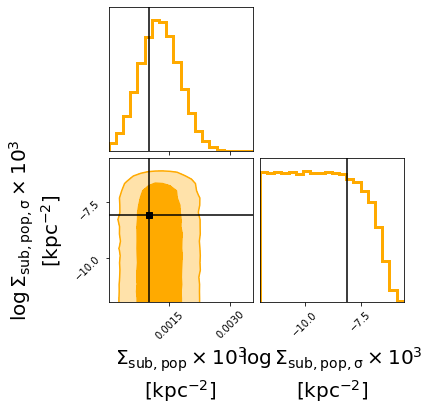

In [5]:
corner_param_print=[r'$\Sigma_\mathrm{sub,pop} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$',
                    r'$\log \Sigma_\mathrm{sub,pop,\sigma} \times 10^{3}$' + '\n' + r'$[\mathrm{kpc}^{-2}]$']
fontsize = 20
color='#FFAA00'
truth_color = 'k'
hist_kwargs = {'density':True,'color':color,'lw':3}

corner.corner(chain,labels=corner_param_print,bins=20,show_titles=False,plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),
              levels=[0.68,0.95],color=color,fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',truths=true_hyperparameters,
              truth_color=truth_color,max_n_ticks=3)
plt.show()

You have an unbiased inference of the mean, and it's clear from this data that the constrain on the scatter is an upper limit (not suprising given the small scatter and the large uncertainty of the information we assigned to each data point). 

In [11]:
chain

NameError: name 'chain' is not defined